# What factors drive current pharmacetical spending?

#### Setup

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

In [2]:
claims = pd.read_csv('claims_2023q4_2024q1.csv', low_memory=False)

In [3]:
claims = claims.drop(columns=[
    # 'tp_code', 'tp_name', 
    'date', 'store_num',
    'rx_number', 'refill_num', 'sold_date'
])

# Create the 'drug' column by extracting the first word from 'product'
claims['drug'] = claims['product'].str.extract(r'^(\w+)')

claims['margin'] = claims.total_price - claims.acq_cost
claims = claims.drop(index=406658)

In [4]:
claims.head()

,product,ndc,gsn,qty,acq_cost,total_price,tp_code,tp_name,generic,drug,margin
0,AMPHETAMINE-DEXTROAMPHETAMI 30 TABS,16714-0808-01,34359.0,60.0,26.12,44.40,100711,BCBS MINNESOTA,G,AMPHETAMINE,18.28
1,METHYLPHENIDATE HCL 20MG TABS,00406-1146-01,4027.0,60.0,89.89,10.00,100717,MEDCO/ESI PEU,G,METHYLPHENIDATE,-79.89
2,AMPHETAMINE-DEXTROAMPHETAMI 30 TABS,16714-0808-01,34359.0,60.0,26.12,10.77,30130,PCN IRX,G,AMPHETAMINE,-15.35
3,HYDROCODONE-ACETAMINOPH 10-325 TABS,27808-0037-01,30623.0,90.0,8.34,8.40,99692,HUMANA MEDICARE,G,HYDROCODONE,0.06
4,HYDROMORPHONE HCL 4MG TABS,00406-3244-01,NaN,84.0,14.81,5.19,71573,APM/CARMRK,G,HYDROMORPHONE,-9.62


In [5]:
print('The total sales for this period were 'f"${round(sum(claims.total_price)):,.0f}")

The total sales for this period were $35,891,291


In [6]:
claims_by_drug = claims.groupby('drug').agg({
    'qty': 'sum',
    'acq_cost': 'sum',
    'total_price': 'sum',
    'drug': 'count',
    'margin': 'sum'
})

# Rename the column for clarity
claims_by_drug = claims_by_drug.rename(columns={'drug': 'num_claims'})

In [7]:
claims_by_drug['avg_claim'] = (claims_by_drug.total_price / claims_by_drug.num_claims).round(2)
claims_by_drug['% of total'] = ((claims_by_drug.total_price / claims_by_drug.total_price.sum()) * 100).round(2)
claims_by_drug['margin_pct'] = ((claims_by_drug.margin / claims_by_drug.total_price) * 100).round(1)
claims_by_drug.head()

,qty,acq_cost,total_price,num_claims,margin,avg_claim,% of total,margin_pct
drug,,,,,,,,
ABILIFY,53.0,125958.77,127985.88,53,2027.11,2414.83,0.36,1.6
ABIRATERONE,240.0,620.00,528.50,2,-91.50,264.25,0.00,-17.3
ABRYSVO,175.5,49724.91,55858.04,178,6133.13,313.81,0.16,11.0
ABSORICA,180.0,6918.42,5797.02,5,-1121.40,1159.40,0.02,-19.3
ACAMPROSATE,1200.0,530.02,770.16,12,240.14,64.18,0.00,31.2


In [8]:
top_drugs = claims_by_drug.sort_values(by='total_price', ascending=False)
top_drugs = top_drugs.loc[top_drugs.total_price > 1000]
top_drugs

,qty,acq_cost,total_price,num_claims,margin,avg_claim,% of total,margin_pct
drug,,,,,,,,
OZEMPIC,10621.0,3224476.67,3220821.76,3346,-3654.91,962.59,8.97,-0.1
MOUNJARO,4400.0,2206763.17,2186195.74,2108,-20567.43,1037.09,6.09,-0.9
ELIQUIS,183334.0,1697090.15,1738159.33,2408,41069.18,721.83,4.84,2.4
JARDIANCE,88833.0,1705971.26,1699905.02,2073,-6066.24,820.02,4.74,-0.4
TRULICITY,2222.0,1016229.88,1017015.74,1005,785.86,1011.96,2.83,0.1
...,...,...,...,...,...,...,...,...
EYSUVIS,16.6,965.89,1011.12,2,45.23,505.56,0.00,4.5
RECTIV,60.0,1233.42,1010.32,1,-223.10,1010.32,0.00,-22.1
GRASTEK,90.0,1000.29,1010.13,3,9.84,336.71,0.00,1.0


### Ten drugs account for 37% of prescription spending.

In [9]:
top_10 = top_drugs.head(10)
round(sum(top_10['% of total']),2)

37.02

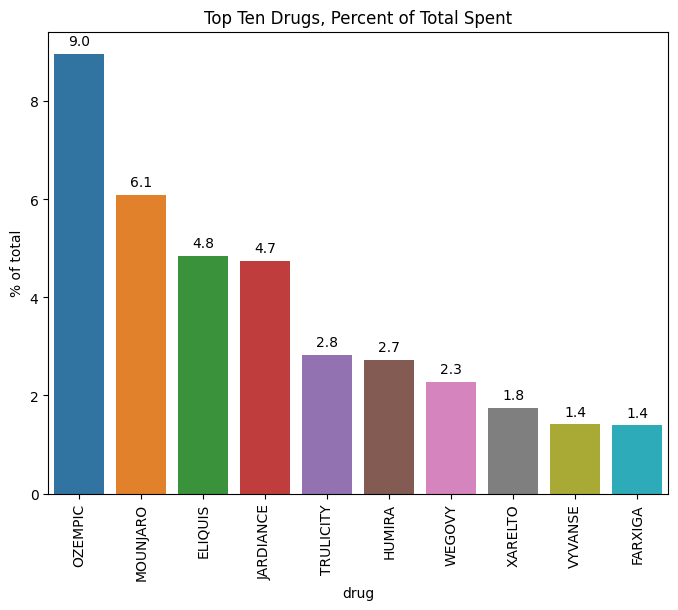

In [10]:
plt.figure(figsize = (8, 6))
ax = sns.barplot(top_10, x=top_10.index, y='% of total')
plt.title('Top Ten Drugs, Percent of Total Spent')
plt.xticks(rotation=90)

for p in ax.patches:
    ax.annotate(format(p.get_height(), '.1f'),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'center', 
                xytext = (0, 9), 
                textcoords = 'offset points')

plt.show()

### The popularity of GLP-1 medications has driven spending while driving down margins for pharmacies

Over the past few years, a major trend in healthcare and pharmacoeconomics has been the rise of glucagon-like peptide-1 receptor agonists, which are often shortened to GLP or GLP-1, and usually associated by the broader public with the most common example, Ozempic. The two medications with the highest drug spend were Ozempic and Mounjaro, two GLPs that combined for more than 15% of money spent on medications.

In [11]:
glp_list = ['OZEMPIC', 'MOUNJARO', 'WEGOVY', 'TRULICITY', 'RYBELSUS', 'ZEPBOUND']
top_drugs.loc[top_drugs.index.isin(glp_list)]

,qty,acq_cost,total_price,num_claims,margin,avg_claim,% of total,margin_pct
drug,,,,,,,,
OZEMPIC,10621.0,3224476.67,3220821.76,3346,-3654.91,962.59,8.97,-0.1
MOUNJARO,4400.0,2206763.17,2186195.74,2108,-20567.43,1037.09,6.09,-0.9
TRULICITY,2222.0,1016229.88,1017015.74,1005,785.86,1011.96,2.83,0.1
WEGOVY,1828.0,830537.86,812981.92,622,-17555.94,1307.04,2.27,-2.2
RYBELSUS,8040.0,244831.23,241628.16,224,-3203.07,1078.70,0.67,-1.3
ZEPBOUND,384.0,194423.46,200043.52,192,5620.06,1041.89,0.56,2.8


In [12]:
ozempic = claims.loc[claims['drug'] == 'OZEMPIC']

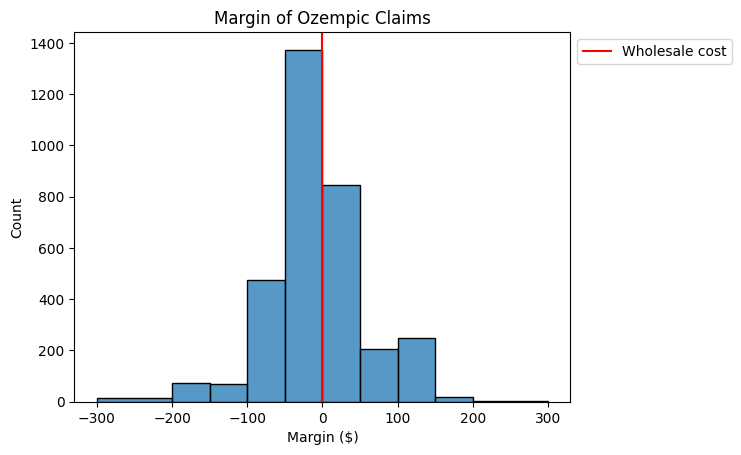

In [13]:
_ = sns.histplot(ozempic, x='margin', bins=[-300, -200, -150, -100, -50, 0, 50, 100, 150, 200, 300])
_ = plt.axvline(x=0, color = 'r', label = 'Wholesale cost')
_ = plt.legend(bbox_to_anchor = (1.0, 1), loc = 'upper left')
_ = plt.title('Margin of Ozempic Claims')
_ = plt.xlabel('Margin ($)')
plt.show()

In [14]:
mounjaro = claims.loc[claims['drug'] == 'MOUNJARO']
# Upon manual review, all records excluded here are incorrect
mounjaro = mounjaro.loc[mounjaro['margin'] < 400]

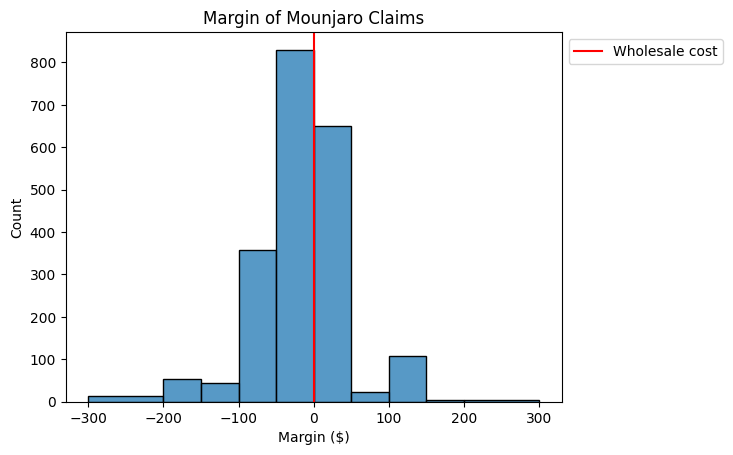

In [15]:
_ = sns.histplot(mounjaro, x='margin', bins=[-300, -200, -150, -100, -50, 0, 50, 100, 150, 200, 300])
_ = plt.axvline(x=0, color = 'r', label = 'Wholesale cost')
_ = plt.legend(bbox_to_anchor = (1.0, 1), loc = 'upper left')
_ = plt.title('Margin of Mounjaro Claims')
_ = plt.xlabel('Margin ($)')
plt.show()

The recent popluarity of these medications has had a negative impact on pharmacies. Their high cost and low insurance reimbursement rates lead to negative returns on large outlays of capital.

In [16]:
top_margin = top_drugs.sort_values(by='margin', ascending=False).head(10)
top_margin

,qty,acq_cost,total_price,num_claims,margin,avg_claim,% of total,margin_pct
drug,,,,,,,,
AMPHETAMINE,471904.0,182652.08,299093.82,9319,116441.74,32.10,0.83,38.9
FLUAD,1114.5,111043.52,200974.86,2229,89931.34,90.16,0.56,44.7
PANTOPRAZOLE,358691.0,22082.15,93577.24,6033,71495.09,15.51,0.26,76.4
TRIENTINE,480.0,2331.56,72955.56,2,70624.00,36477.78,0.20,96.8
ROSUVASTATIN,344130.0,38180.09,108692.21,6134,70512.12,17.72,0.30,64.9
ATORVASTATIN,626415.0,70956.37,139041.39,10866,68085.02,12.80,0.39,49.0
LEVOTHYROXINE,443677.0,43874.12,109750.20,8382,65876.08,13.09,0.31,60.0
LOSARTAN,438517.0,25782.07,91342.84,7649,65560.77,11.94,0.25,71.8
HYDROCODONE,458667.0,67258.69,120862.62,7266,53603.93,16.63,0.34,44.4


### The highest-margin drugs tend to be generic medications with relatively low prices

In [17]:
top_margin_index = top_margin.head(5).reset_index()
margin_melt = top_margin_index.melt(id_vars='drug', value_vars=['total_price','acq_cost'])

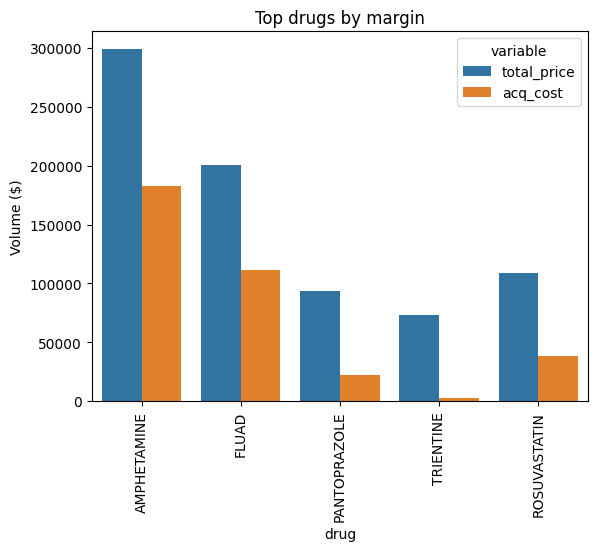

In [18]:
sns.barplot(margin_melt, x='drug', y='value', hue='variable')
plt.ylabel('Volume ($)')
plt.title('Top drugs by margin')
plt.xticks(rotation=90)
plt.show()

### The top-selling drugs (by $ volume) all have low-to-negative margins

In [19]:
top_5_index = top_10.head(5).reset_index()
top_5_melt = top_5_index.melt(id_vars='drug', value_vars=['total_price','acq_cost'])

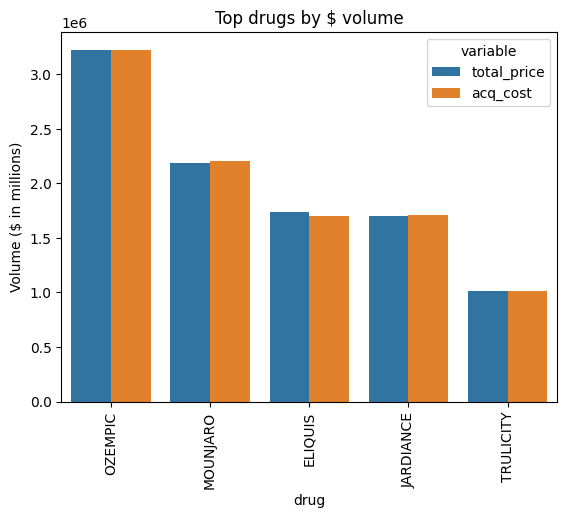

In [20]:
sns.barplot(top_5_melt, x='drug', y='value', hue='variable')
plt.ylabel('Volume ($ in millions)')
plt.title('Top drugs by $ volume')
plt.xticks(rotation=90)
plt.show()

### Combined comparison

In [21]:
combined_melt = pd.concat([top_5_melt, margin_melt])

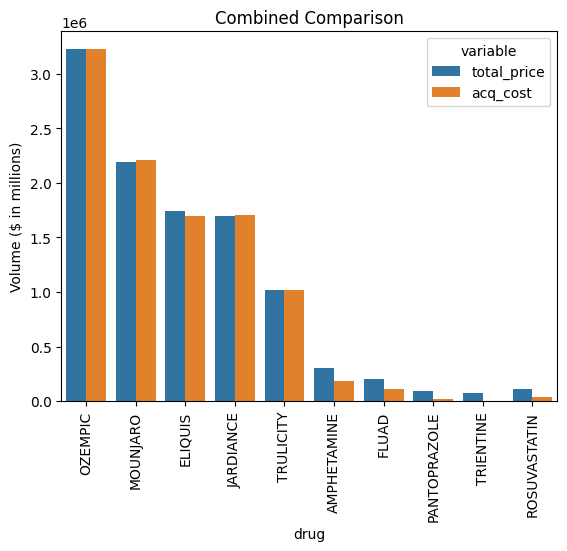

In [22]:
sns.barplot(combined_melt, x='drug', y='value', hue='variable')
plt.xticks(rotation=90)
plt.ylabel('Volume ($ in millions)')
plt.title('Combined Comparison')
plt.show()

Expensive branded medications account for an outsized proportion of pharmaceutical spending, while being simultaneously detrimental to cash flow and profitability of pharmacies. These trends are only accelerating with the rising popularity of GLP-1 products. Pharmacy profitability is driven by margins on generic drugs, but reimbursement rates have fallen in recent years, leading to many pharmacy closures.

### Generic Case Study: Atorvastatin

Atorvastatin is a cholesterol medication which became the highest-grossing pharmaceutical product of all time under the brand name Lipitor. Now available generically at a wholesale cost of less than $5 per month, it is representative of the generic products pharmacies rely on to support profitability.

Below: Generic Sequence Number (GSN) refers to a specific drug, dosage form, and strength. GSN 29969 refers to atorvastatin 40mg tablets, one of the most commonly filled products in this dataset.

In [23]:
claims.value_counts().groupby('gsn').sum().sort_values(ascending=False).head()

gsn
27462.0    5500
28090.0    5000
47430.0    4150
29969.0    3816
24668.0    3765
Name: count, dtype: int64

In [24]:
def gsn_claims(gsn):
   return claims.loc[claims.gsn == gsn].copy()

In [25]:
atorvastatin40 = gsn_claims(29969)

In [26]:
atorvastatin40['price_per_month'] = atorvastatin40.total_price / (atorvastatin40.qty / 30)

In [27]:
atorvastatin40.drop(index=[118776, 245602], inplace=True)
atorvastatin40.drop(atorvastatin40.loc[atorvastatin40.tp_code == '1'].index, inplace=True)
atorvastatin40 = atorvastatin40.drop(columns=['tp_code', 'tp_name'])

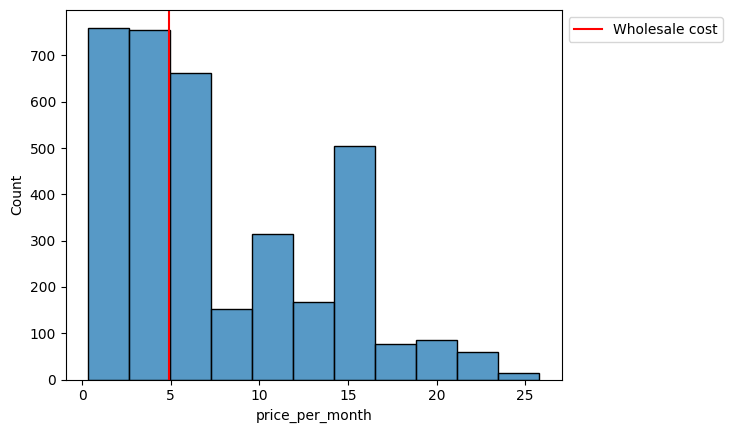

In [28]:
_ = sns.histplot(atorvastatin40, x='price_per_month', bins=11)
_ = plt.axvline(x=4.90, color = 'r', label = 'Wholesale cost')
_ = plt.legend(bbox_to_anchor = (1.0, 1), loc = 'upper left')
plt.show()

As this figure shows, many claims are reimbursed below the cost of the tablets themselves, and many more are below-cost when other factors outside of this analysis are accounted for. The wide spread of reimbursement rates add to the financial difficulties pharmacies face today.